In [1]:
import jax
import jax.numpy as jnp
from jax import config
import matplotlib.pyplot as plt
import diffrax as dfx
from functools import partial

config.update("jax_enable_x64", True)

class PDE:
    def __init__(self, **kwargs):
        """
        Initialize PDE solver with physical and discretization parameters.

        Parameters
        ----------
        kwargs : dict
            Dictionary containing physical parameters (alpha_phi, omega_phi, M, A, L, c_se, c_le)
            and discretization arrays (x, t).
        """
        self.alpha_phi = kwargs["alpha_phi"]
        self.omega_phi = kwargs["omega_phi"]
        self.M         = kwargs["M"]
        self.A         = kwargs["A"]
        self.L         = kwargs["L"]
        self.c_se      = kwargs["c_se"]
        self.c_le      = kwargs["c_le"]
        self.x_range   = kwargs["x_range"]
        self.t_range   = kwargs["t_range"]
        self.nx        = kwargs["nx"]
        self.nt        = kwargs["nt"]
        self.x         = jnp.linspace(self.x_range[0], self.x_range[1], self.nx)
        self.t_eval    = jnp.linspace(self.t_range[0], self.t_range[1], self.nt)
        self.dx        = self.x[1] - self.x[0]

    @staticmethod
    def h(phi):
        """ Interpolation function h(phi). """
        return -2 * phi**3 + 3 * phi**2

    @staticmethod
    def h_p(phi):
        """ First derivative of h(phi) wrt phi. """
        return -6 * phi**2 + 6 * phi

    @staticmethod
    def h_pp(phi):
        """ Second derivative of h(phi) wrt phi. """
        return -12.0 * phi + 6.0

    @staticmethod
    def g_p(phi):
        """ First derivative of double-well potential g(phi) wrt phi. """
        return 2 * phi * (1 - phi) * (2 * phi - 1)

    def phi_ic(self, x, t, x_init_interface=0.0):
        """ Initial condition for phi. """
        xd = x - x_init_interface
        scale = (self.omega_phi)**0.5 / (2.0 * self.alpha_phi)**0.5
        return 0.5 * (1.0 - jnp.tanh(scale * xd))

    def c_ic(self, x, t, x_init_interface=0.0):
        """ Initial condition for c. """
        phi = self.phi_ic(x, t, x_init_interface)
        return self.h(phi) * self.c_se

    def phi_bc(self, x, t):
        """ Boundary condition for phi. """
        return jnp.where(x < 0, 1.0, 0.0)

    def c_bc(self, x, t):
        """ Boundary condition for c. """
        return jnp.where(x < 0, 1.0, 0.0)

    def laplacian(self, f):
        """
        Second-order finite-difference Laplacian.

        Parameters
        ----------
        f : jnp.ndarray
            Input array, shape (self.nx,)

        Returns
        -------
        jnp.ndarray
            Discrete Laplacian, shape (self.nx,)
        """
        lap = jnp.zeros_like(f)
        interior = (f[2:] - 2 * f[1:-1] + f[:-2]) / self.dx**2
        lap = lap.at[1:-1].set(interior)
        return lap

    @partial(jax.jit, static_argnums=(0,))
    def rhs(self, t, y, p):
        """
        Right-hand side function for ODE solver.

        Parameters
        ----------
        t : float
            Time.
        y : jnp.ndarray
            State vector [c, φ], shape (2*self.nx,)
        p : dict
            Parameter dictionary.

        Returns
        -------
        jnp.ndarray
            Time derivative dy/dt, shape (2*self.nx,)
        """
        A, M, L = p["A"], p["M"], p["L"]
        c_se, c_le = p["c_se"], p["c_le"]
        alpha_phi, omega_phi = p["alpha_phi"], p["omega_phi"]

        c, phi = jnp.split(y, 2)

        phi = phi.at[0].set(self.phi_bc(self.x[0],  t))
        phi = phi.at[-1].set(self.phi_bc(self.x[-1], t))
        c   = c.at[0].set(self.c_bc(self.x[0],      t))
        c   = c.at[-1].set(self.c_bc(self.x[-1],    t))

        h_phi     = self.h(phi)
        dh_dphi   = self.h_p(phi)
        lap_c     = self.laplacian(c)
        lap_phi   = self.laplacian(phi)
        lap_h_phi = self.laplacian(h_phi)

        dc_dt = 2 * A * M * (lap_c - (c_se - c_le) * lap_h_phi)
        reaction = 2 * A * (c_se - c_le) * (c - h_phi * (c_se - c_le) - c_le)
        dphi_dt = L * (alpha_phi * lap_phi + reaction * dh_dphi + omega_phi * self.g_p(phi))

        bc_idx = jnp.array([0, -1])
        dc_dt = dc_dt.at[bc_idx].set(0.0)
        dphi_dt = dphi_dt.at[bc_idx].set(0.0)

        return jnp.concatenate([dc_dt, dphi_dt])

    def solve(self, **params):
        """
        Solve the coupled PDE system.

        Parameters
        ----------
        params : dict
            Optional override for physical parameters.

        Returns
        -------
        x : jnp.ndarray
            Spatial grid, shape (self.nx,)
        t_eval : jnp.ndarray
            Time points, shape (self.nt,)
        c : jnp.ndarray
            Concentration field c(x, t), shape (self.nt, self.nx)
        phi : jnp.ndarray
            Phase field φ(x, t), shape (self.nt, self.nx)
        """
        p = dict(
            alpha_phi=self.alpha_phi, omega_phi=self.omega_phi,
            M=self.M, A=self.A, L=self.L,
            c_se=self.c_se, c_le=self.c_le,
        )
        p.update(params)

        phi0 = self.phi_ic(self.x, 0.0)
        phi0 = phi0.at[0].set(self.phi_bc(self.x[0],  0.0))
        phi0 = phi0.at[-1].set(self.phi_bc(self.x[-1], 0.0))

        c0 = self.c_ic(self.x, 0.0)
        c0 = c0.at[0].set(self.c_bc(self.x[0],   0.0))
        c0 = c0.at[-1].set(self.c_bc(self.x[-1], 0.0))

        y0 = jnp.concatenate([c0, phi0])

        term   = dfx.ODETerm(self.rhs)
        solver = dfx.Kvaerno5()
        sol    = dfx.diffeqsolve(
            term, solver,
            t0=self.t_eval[0], t1=self.t_eval[-1], dt0=1.0,
            y0=y0, args=p,
            stepsize_controller=dfx.PIDController(rtol=1e-8, atol=1e-10),
            saveat=dfx.SaveAt(ts=self.t_eval),
            max_steps=1_000_000,
        )

        y   = sol.ys
        c   = y[:, :self.nx]
        phi = y[:, self.nx:]
        return self.x, self.t_eval, c, phi

    def draw_heatmap(self, x, t, C, P):
        """
        Plot heatmaps of φ(x, t) and c(x, t).

        Parameters
        ----------
        x : array_like
            Spatial grid, shape (self.nx,)
        t : array_like
            Time points, shape (self.nt,)
        C : array_like
            Concentration field, shape (self.nt, self.nx)
        P : array_like
            Phase field, shape (self.nt, self.nx)
        """
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))

        im0 = ax[0].imshow(
            P, origin='lower', aspect='auto',
            extent=[x[0] * 1e6, x[-1] * 1e6, t[0], t[-1]],
            cmap='viridis', vmin=0, vmax=1,
        )
        ax[0].set_title('Phase Field φ(x, t)', fontsize=14)
        ax[0].set_xlabel('Position x (μm)')
        ax[0].set_ylabel('Time (s)')
        fig.colorbar(im0, ax=ax[0], label='φ')

        im1 = ax[1].imshow(
            C, origin='lower', aspect='auto',
            extent=[x[0] * 1e6, x[-1] * 1e6, t[0], t[-1]],
            cmap='inferno',
        )
        ax[1].set_title('Concentration c(x, t)', fontsize=14)
        ax[1].set_xlabel('Position x (μm)')
        ax[1].set_ylabel('Time (s)')
        fig.colorbar(im1, ax=ax[1], label='c (mole fraction)')

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    def draw_profiles(self, x, t, C, P, num_profiles=10):
        """
        Plot φ(x) and c(x) at several time snapshots.

        Parameters
        ----------
        x : array_like
            Spatial grid, shape (self.nx,)
        t : array_like
            Time points, shape (self.nt,)
        C : array_like
            Concentration field, shape (self.nt, self.nx)
        P : array_like
            Phase field, shape (self.nt, self.nx)
        num_profiles : int
            Number of time profiles to plot.
        """
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        indices = jnp.linspace(0, len(t) - 1, num_profiles, dtype=int)

        for i in indices:
            ax[0].plot(x * 1e6, P[i, :], label=f't = {t[i]:.2e} s')
        ax[0].set_title('Phase Field φ(x)')
        ax[0].set_xlabel('Position x (μm)')
        ax[0].set_ylabel('φ')
        ax[0].legend()
        ax[0].grid(True, linestyle=':')

        for i in indices:
            ax[1].plot(x * 1e6, C[i, :], label=f't = {t[i]:.2e} s')
        ax[1].set_title('Concentration c(x)')
        ax[1].set_xlabel('Position x (μm)')
        ax[1].set_ylabel('c')
        ax[1].legend()
        ax[1].grid(True, linestyle=':')

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


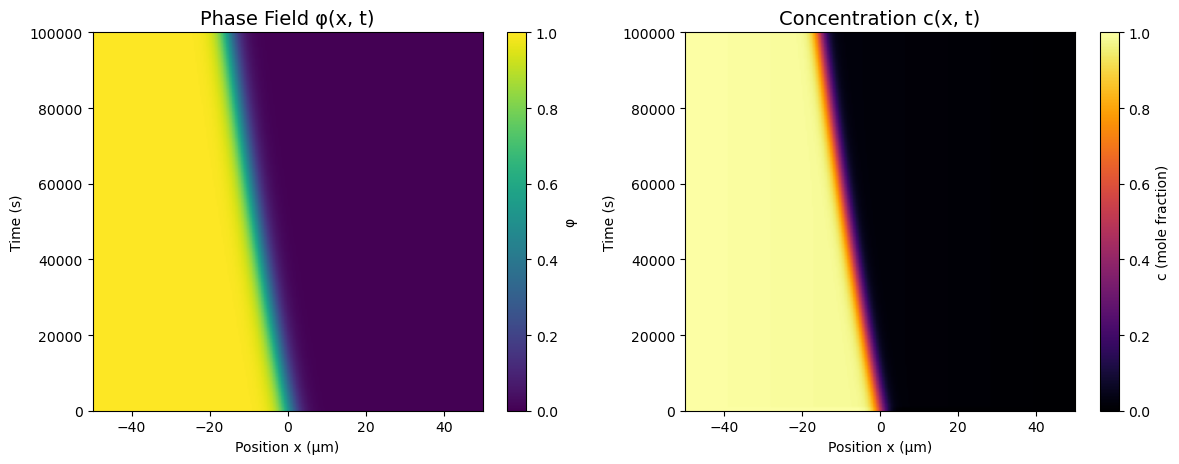

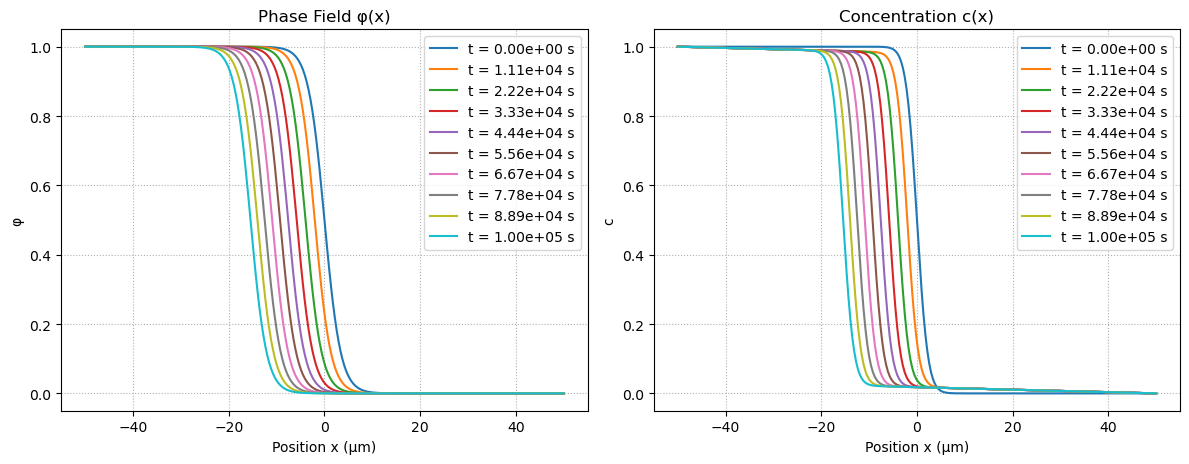

In [2]:

if __name__ == "__main__":
    # Parameters from Table 2 of the paper
    params = {
        "alpha_phi": 9.62e-5,
        "omega_phi": 1.663e7,
        "L": 1.0e-11,           # For activation-controlled case (Section 5.2.1)
        "M": 8.5e-10/(2*5.35e7),
        "A": 5.35e7,
        "c_se": 1.0,
        "c_le": 5100/1.43e5,
        "x_range": (-50e-6, 50e-6),
        "t_range": (0, 1e5),
        "nx": 256,
        "nt": 100
    }
    
    ACCH = PDE(**params)
    x, t, C, P = ACCH.solve()
    ACCH.draw_heatmap(x, t, C, P)
    ACCH.draw_profiles(x, t, C, P) # Add this call